In [15]:
#coding: utf-8
import cython
import numpy as np
import pandas as pd
import scipy
import pymysql
from numba import jit
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import wrapt
import time
import os
from multiprocessing import Pool
%matplotlib inline
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [16]:
def RBreaker(yes_high,yes_low,yes_close):
    s_setup=yes_high+0.35*(yes_close-yes_low)
    b_setup=yes_low-0.35*(yes_high-yes_close)
    senter=1.07/2*(yes_high+yes_low)-0.07*yes_low
    benter=1.07/2*(yes_high+yes_low)-0.07*yes_high
    b_break=s_setup+0.25*(s_setup-b_setup)
    s_break=b_setup-0.25*(s_setup-b_setup)
    return [s_setup,b_setup,senter,benter,b_break,s_break]

In [17]:
def rbreaker(category):
    intra_df=pd.read_csv('%s_intraday.csv'%category.lower(),encoding='gbk')
    intra_df['update_date']=pd.to_datetime(intra_df['update_date'])

    interday_df=pd.read_csv('%s_interday.csv'%category.lower(),encoding='gbk',header=3)
    interday_df['Date']=pd.to_datetime(interday_df['Date'])
    interday_df=interday_df.rename(columns={'Date':'update_date'})
    interday_df['open']=interday_df['open'].astype(float)
    interday_df['high']=interday_df['high'].astype(float)
    interday_df['low']=interday_df['low'].astype(float)
    interday_df['close']=interday_df['close'].astype(float)

    interday_df['high_yes']=interday_df['high'].shift(1)
    interday_df['low_yes']=interday_df['low'].shift(1)
    interday_df['close_yes']=interday_df['close'].shift(1)

    rb=map(RBreaker,interday_df['high_yes'],interday_df['low_yes'],interday_df['close_yes'])

    rb=pd.DataFrame(rb,columns=['s_setup','b_setup','senter','benter','b_break','s_break'])
    rb['update_date']=interday_df['update_date']

    rb=rb.rename(columns={'update_date':'date'})
    rb['date']=pd.to_datetime(rb['date'])

    intra_df['date']=intra_df['update_date'].apply(lambda x:x.date() if x.hour<21 else pd.to_datetime(x+np.timedelta64(1,'D')).date())
    intra_df['date']=pd.to_datetime(intra_df['date'])

    intra_df=pd.merge(intra_df,rb,on=['date'],how='inner')

    intra_df=intra_df.dropna(axis=0)

    intra_df=intra_df.drop(['volume'],axis=1)

    intra_df_cop=pd.DataFrame()
    for i,j in intra_df.groupby(['date']):
        j=j.sort('update_date')
        stop_loss_point=list(j['open'])[0]
        j['high_max']=j['high'].cummax()
        j['low_min']=j['low'].cummin()


        col_list=list(j.columns)
        open_lab=col_list.index('open')
        high_lab=col_list.index('high')
        low_lab=col_list.index('low')
        close_lab=col_list.index('close')
        s_setup_lab=col_list.index('s_setup')
        b_setup_lab=col_list.index('b_setup')
        senter_lab=col_list.index('senter')
        benter_lab=col_list.index('benter')
        b_breaker_lab=col_list.index('b_break')
        s_breaker_lab=col_list.index('s_break')
        high_max_lab=col_list.index('high_max')
        low_min_lab=col_list.index('low_min')

        p_mat=j.as_matrix()
        sig=np.zeros(p_mat.shape[0],dtype=np.float)
        for k in range(1,p_mat.shape[0]-1):
            #突破做多
            if p_mat[k,high_lab]>p_mat[k,b_breaker_lab]:
                sig[k+1]=1
            elif p_mat[k,low_lab]>stop_loss_point and sig[k]==1:
                sig[k+1]=1
            #突破做空
            elif p_mat[k,low_lab]<p_mat[k,s_breaker_lab]:
                sig[k+1]=-1
            elif p_mat[k,high_lab]<stop_loss_point and sig[k]==-1:
                sig[k+1]=-1
            #反转做多做空
            else:
                if p_mat[k,high_max_lab]<p_mat[k,b_breaker_lab] and p_mat[k,high_max_lab]>p_mat[k,s_setup_lab] and p_mat[k,low_lab]<p_mat[k,senter_lab]:
                    sig[k+1]=-1
                elif p_mat[k,low_min_lab]>p_mat[k,s_breaker_lab] and p_mat[k,low_min_lab]<p_mat[k,b_setup_lab] and p_mat[k,high_lab]>p_mat[k,benter_lab]:
                    sig[k+1]=1
                else:
                    sig[k+1]=0



        j['sig']=sig
        intra_df_cop=intra_df_cop.append(j)

    intra_df_cop['return']=intra_df_cop['pctchange']*intra_df_cop['sig']

    intra_df_cop['cum']=intra_df_cop['return'].cumsum()
    return intra_df_cop

In [18]:
intra_df_cop_al=rbreaker('al')
intra_df_cop_cu=rbreaker('cu')
intra_df_cop_zn=rbreaker('zn')

/Users/liyuefan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [19]:
intra_df_cop_al_std=pd.DataFrame(intra_df_cop_al.groupby(['date']).pctchange.std())
intra_df_cop_al_std=intra_df_cop_al_std.rename(columns={'pctchange':'al'})

intra_df_cop_cu_std=pd.DataFrame(intra_df_cop_cu.groupby(['date']).pctchange.std())
intra_df_cop_cu_std=intra_df_cop_cu_std.rename(columns={'pctchange':'cu'})

intra_df_cop_zn_std=pd.DataFrame(intra_df_cop_zn.groupby(['date']).pctchange.std())
intra_df_cop_zn_std=intra_df_cop_zn_std.rename(columns={'pctchange':'zn'})

intra_df_cop_std=pd.concat([intra_df_cop_al_std,intra_df_cop_cu_std,intra_df_cop_zn_std],axis=1,join='inner')

In [20]:
intra_df_cop_std.reset_index(inplace=True)

In [21]:
date_array=np.array(intra_df_cop_std['date'])
std_mat=intra_df_cop_std[['al','cu','zn']]
category_list=['al','cu','zn']
std_mat=std_mat.as_matrix()

In [22]:
total_df=pd.DataFrame()
for i in range(std_mat.shape[0]-1):
    tmp=std_mat[i,:]
    idx=np.argmin(tmp)
    cat=category_list[idx]
    d=date_array[i+1]
    dd=eval("intra_df_cop_%s[intra_df_cop_%s['date']==d][['update_date','sig','return']]"%(cat,cat))
    dd['category']=cat
    total_df=total_df.append(dd)

In [23]:
total_df['cum_return']=total_df['return'].cumsum()

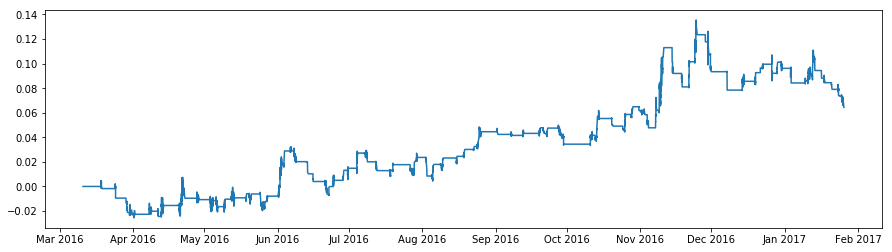

In [24]:
plt.figure(figsize=(15,4))
plt.plot(total_df['update_date'],total_df['cum_return'])

In [25]:
total_df

,update_date,sig,return,category,cum_return
692,2016-03-10 21:00:00.005000,0,0.000000,al,0.000000
693,2016-03-10 21:01:00.004997,0,-0.000000,al,0.000000
694,2016-03-10 21:02:00.005003,0,0.000000,al,0.000000
695,2016-03-10 21:03:00.005000,0,-0.000000,al,0.000000
696,2016-03-10 21:04:00.004996,0,0.000000,al,0.000000
697,2016-03-10 21:05:00.005002,0,-0.000000,al,0.000000
698,2016-03-10 21:06:00.004999,0,0.000000,al,0.000000
699,2016-03-10 21:07:00.004995,0,0.000000,al,0.000000
700,2016-03-10 21:08:00.005002,0,-0.000000,al,0.000000
701,2016-03-10 21:09:00.004998,0,-0.000000,al,0.000000


In [26]:
total_df['factorize_category']=pd.factorize(total_df['category'])[0]

In [27]:
total_df.index=[total_df['update_date']]

<Container object of 90249 artists>

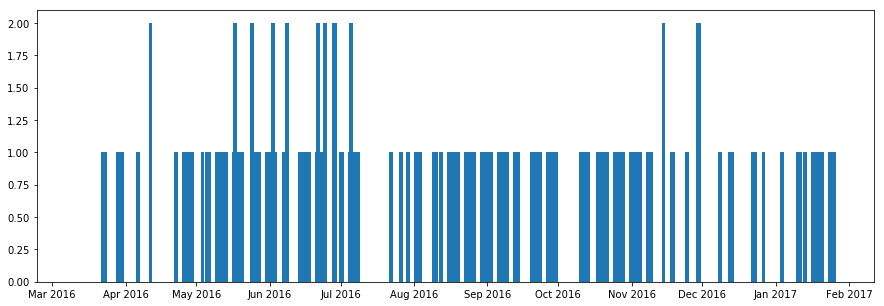

In [28]:
plt.figure(figsize=(15,5))
plt.bar(total_df.index,total_df['factorize_category'])